In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type
from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pull in training data
training_data = pd.read_pickle('data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [5]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [6]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [7]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

In [8]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [9]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [10]:
# Set parameters for the SVM Model
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [11]:
#Determine C-value for SVM via grid search
parameters = {'C':[0.1,1,5,10,15,20]}
estimator = SVC(kernel = 'linear',probability = True)
clf = GridSearchCV(estimator, parameters) 
clf.fit(X_train, Y_train)
clf.cv_results_

{'mean_fit_time': array([254.6182456 , 232.1545526 , 246.87487388, 267.49251647,
        287.03971577, 302.74616256]),
 'std_fit_time': array([2.15680809, 1.15269523, 0.69980793, 2.05150611, 2.43407391,
        2.28460962]),
 'mean_score_time': array([7.11313777, 5.51152101, 5.28195529, 5.18796973, 5.44286637,
        5.29907374]),
 'std_score_time': array([0.35248926, 0.6274791 , 0.73910625, 0.53782615, 0.55152225,
        0.95517436]),
 'param_C': masked_array(data=[0.1, 1, 5, 10, 15, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1}, {'C': 5}, {'C': 10}, {'C': 15}, {'C': 20}],
 'split0_test_score': array([0.82125956, 0.83017838, 0.83163451, 0.83218056, 0.83327266,
        0.83454678]),
 'split1_test_score': array([0.82708409, 0.83454678, 0.83727703, 0.83927921, 0.84000728,
        0.84000728]),
 'split2_test_score': array([0.83618493, 0.84310157, 0.84419367, 0.84528577, 0.84619585,

In [12]:
#Print accuracy
probabilities = cross_val_predict(clf.best_estimator_, X_train, Y_train, cv=kfold, method='predict_proba')
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8385147433563888

Cross validation classification report

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      7189
           1       0.90      0.87      0.89      8015
           2       0.85      0.90      0.87     12266

   micro avg       0.84      0.84      0.84     27470
   macro avg       0.83      0.82      0.83     27470
weighted avg       0.84      0.84      0.84     27470
 samples avg       0.84      0.84      0.84     27470



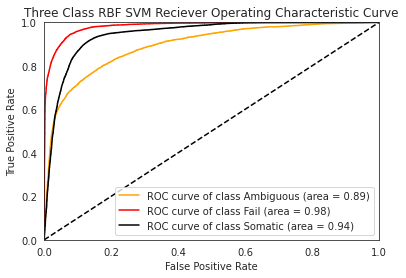

In [13]:
# Plot ROC for SVM
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class RBF SVM Reciever Operating Characteristic Curve', ax)

In [14]:
# Rebuild SVM model
svm = clf.best_estimator_.fit(X_train, Y_train)

In [71]:
# Create function to determine the feature importance 
def create_feature_importance_plot(trained_model):
    importance = abs(trained_model.coef_[0])
    features = training_data.drop(['call'], axis=1).columns.values
    importance,features = zip(*sorted(zip(importance,features)))
    features = tuple([s.replace('ref', 'reference') for s in[s.replace('_', ' ') for s in[s.replace('avg', 'average') for s in[s.replace('var', 'variant') for s in list(features)]]]])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.barh(range(15), importance[-15:], align='center')
    plt.yticks(range(15), features[-15:])
    plt.show()

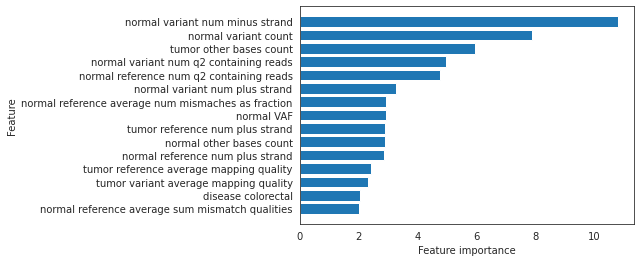

In [72]:
# Plot feature importance graph
create_feature_importance_plot(svm)

In [17]:
# Determine performance on test set
test_prob = svm.predict_proba(X_test)

In [18]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

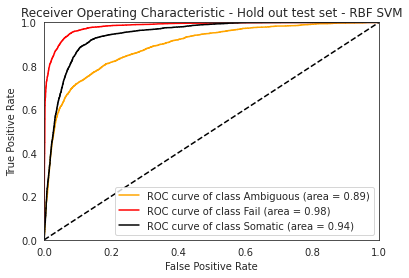

In [19]:
# Plot AUC for test set
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating Characteristic - Hold out test set - RBF SVM', ax)